# Black-Litterman model

An asset allocation model which is considered to be an adaptation of Modern Portfolio Theory, which only included market historical data, and constructs portfolios based on those returns.

This model instead takes into account the investor's views of the asset's future performance, and constructs more optimal portfolios with those performance views.

## Download stock data

In [39]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

import warnings
warnings.filterwarnings('ignore')

In [40]:
# Get the stock tickers
tickers = ['PLTR', 'ATVI', 'NIO', 'NEGG', 'AAPL', 'LOVE', 'JYNT', 'CELH', 'AMD', 'SOFI']

In [41]:
# Download the adjusted closing prices of the stocks
df = yf.download(tickers, period='max')
prices = df['Adj Close']
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AAPL,AMD,ATVI,CELH,JYNT,LOVE,NEGG,NIO,PLTR,SOFI
Date,,,,,,,,,,
2021-11-19,160.550003,155.410004,62.380001,72.839996,93.699997,82.930000,17.379999,38.660000,21.410000,20.370001
2021-11-22,161.020004,152.520004,62.200001,73.440002,88.589996,80.959999,17.889999,41.490002,20.650000,18.750000
2021-11-23,161.410004,149.919998,61.770000,71.599998,84.669998,72.339996,17.500000,42.040001,20.590000,17.809999
2021-11-24,161.940002,157.800003,60.910000,73.290001,83.489998,72.449997,18.379999,41.419998,21.110001,18.330000
2021-11-26,156.809998,154.809998,60.619999,71.379997,79.989998,67.519997,19.840000,39.990002,21.030001,18.209999


In [42]:
# Get the Adjusted closing price of the S&P 500
market_prices = yf.download('SPY', period='max')['Adj Close']
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.717388
1993-02-01    25.900282
1993-02-02    25.955172
1993-02-03    26.229536
1993-02-04    26.339277
Name: Adj Close, dtype: float64

In [43]:
# Download data containing market caps of all the stocks 
from pandas_datareader import data

mcaps = data.get_quote_yahoo(tickers)['marketCap']

In [44]:
mcaps

PLTR      42161364992
ATVI      47442120704
NIO       63606894592
NEGG       7314274304
AAPL    2572687507456
LOVE       1020801088
JYNT       1152919808
CELH       5340301824
AMD      186950090752
SOFI      14561261568
Name: marketCap, dtype: int64

## Getting market-implied returns

In [45]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [46]:
# Get the market-implied risk aversion parameter
# Use the Ledoit-Wolf shrinkage estimator

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.78418583200132

<AxesSubplot:>

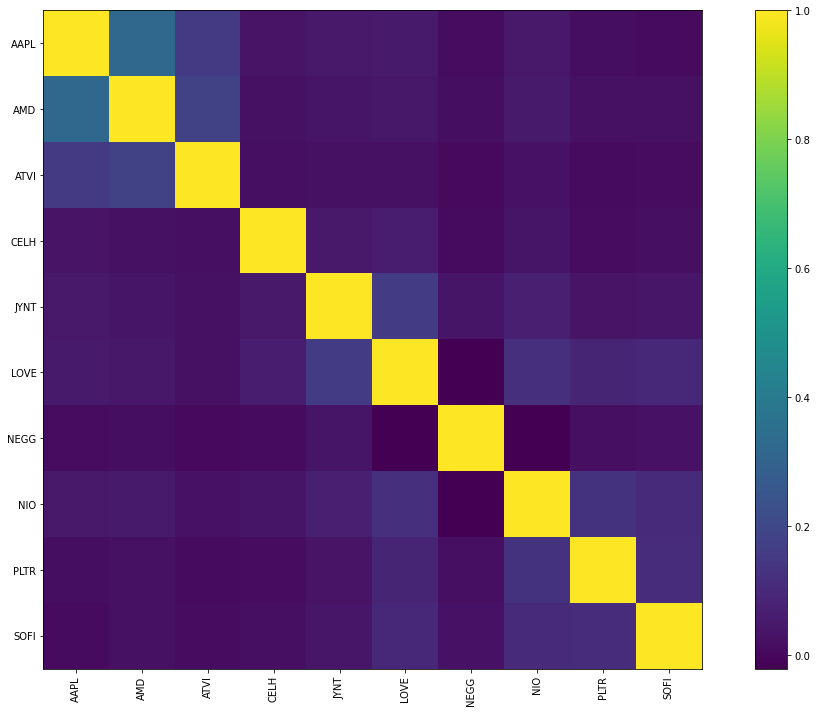

In [47]:
# Plot the covariance matrix
plotting.plot_covariance(S, plot_correlation=True)

In [48]:
# Get the prior estimate of returns implied by market weights 
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.04)
market_prior

AAPL    0.544460
AMD     0.312721
ATVI    0.128651
CELH    0.077016
JYNT    0.054217
LOVE    0.056538
NEGG    0.052571
NIO     0.062654
PLTR    0.044729
SOFI    0.043005
dtype: float64

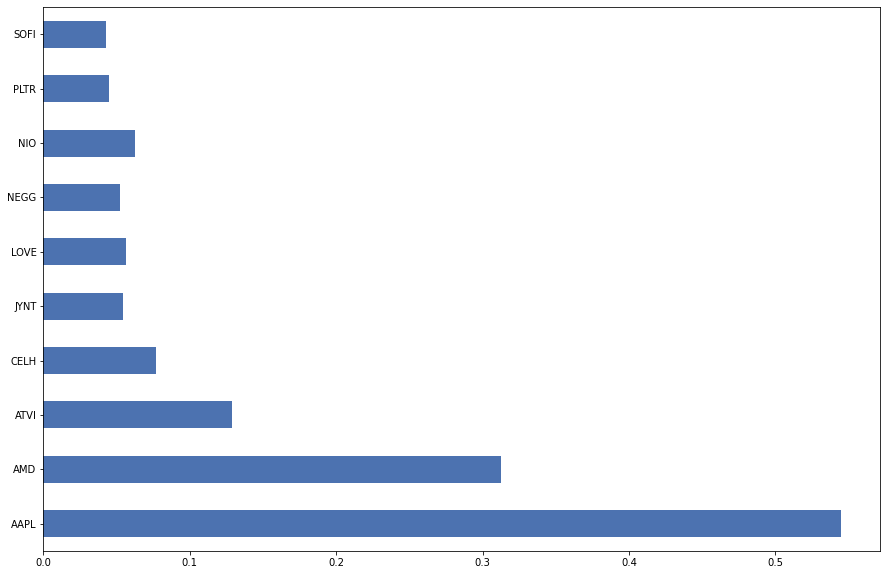

In [49]:
# PLot the market-implied returns
market_prior.plot.barh();

## Provide absolute views of assets' performance

In [50]:
viewdict = {
    'AAPL':0.6,
    'PLTR':0.2,
    'ATVI':0.2,
    'JYNT':0.2,
    'LOVE':0.2,
    'NEGG':0.2,
    'NIO':0.1,
    'CELH':0.1,
    'AMD':0.2
    
}

In [51]:
# Provide confidence percentages of asset performance
confidences = [
    0.8,
    0.6,
    0.6,
    0.7,
    0.4,
    0.6,
    0.4,
    0.4,
    0.5
]


In [52]:
# Input the Black-Litterman model 
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega='idzorek',
                         view_confidences=confidences)

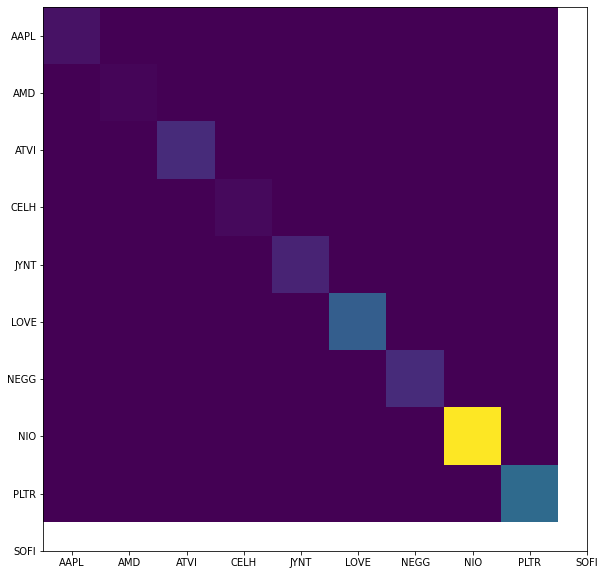

In [53]:
# Show the uncertainty matrix
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(bl.omega)

# show all ticks
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [54]:
np.diag(bl.omega)

array([0.00250304, 0.00074213, 0.00629457, 0.00126096, 0.00500828,
       0.01508783, 0.00629693, 0.0505891 , 0.01754842])

## Posterior Estimates

Compute posterior estimate of returns

In [55]:
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.589781
AMD     0.281453
ATVI    0.173057
CELH    0.105913
JYNT    0.160148
LOVE    0.130701
NEGG    0.147241
NIO     0.098949
PLTR    0.139626
SOFI    0.058895
dtype: float64

In [56]:
# Visualize the comparison between prior and posterior views
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
                      index=['Prior', 'Posterior','Views']).T
rets_df

,Prior,Posterior,Views
AAPL,0.544460,0.589781,0.6
AMD,0.312721,0.281453,0.2
ATVI,0.128651,0.173057,0.2
CELH,0.077016,0.105913,0.1
JYNT,0.054217,0.160148,0.2
LOVE,0.056538,0.130701,0.2
NEGG,0.052571,0.147241,0.2
NIO,0.062654,0.098949,0.1
PLTR,0.044729,0.139626,0.2
SOFI,0.043005,0.058895,NaN


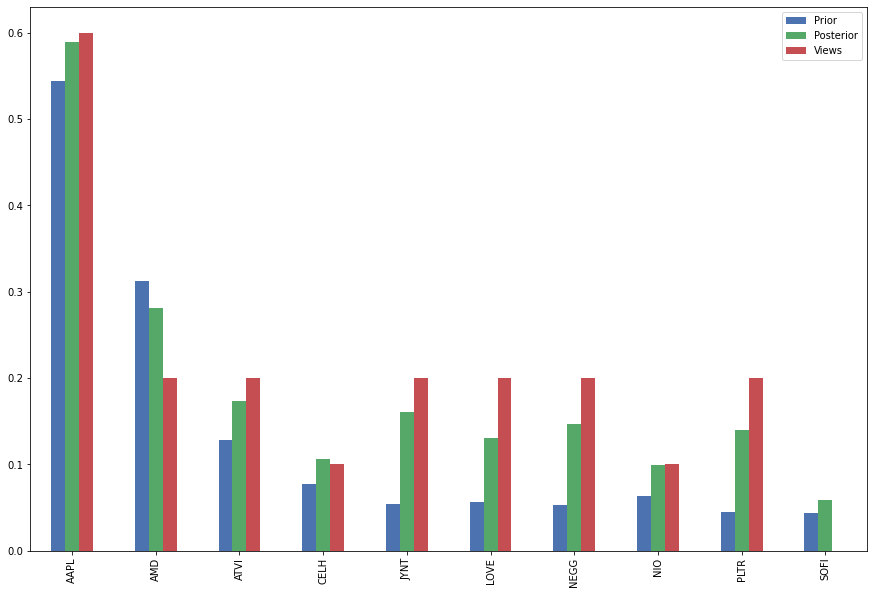

In [57]:
# Plot the above
rets_df.plot.bar();

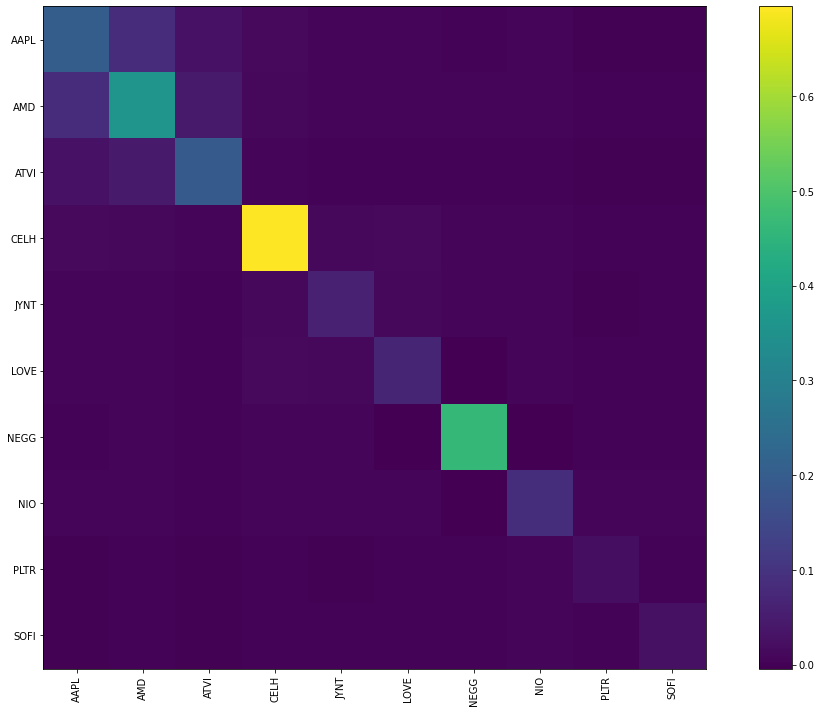

In [58]:
# Plot covariance matrix
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

# Portfolio Optimization

## Optimize for maximum sharpe ratio

In [59]:
from pypfopt import EfficientFrontier, objective_functions

In [60]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.23238),
             ('AMD', 0.0),
             ('ATVI', 0.02865),
             ('CELH', 0.0012),
             ('JYNT', 0.15884),
             ('LOVE', 0.07278),
             ('NEGG', 0.01849),
             ('NIO', 0.01541),
             ('PLTR', 0.41669),
             ('SOFI', 0.05556)])

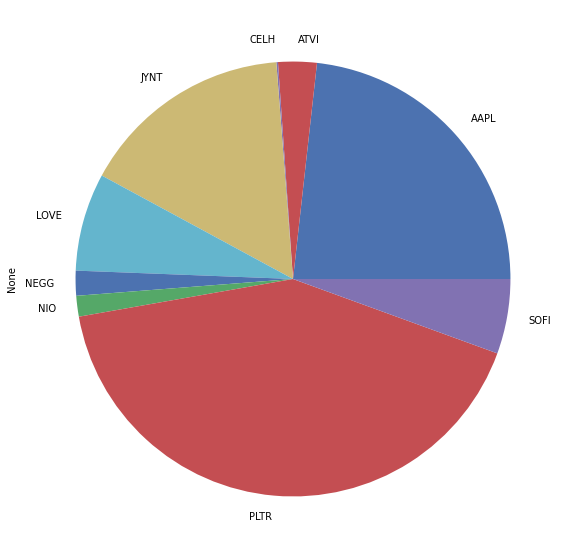

In [61]:
pd.Series(weights).plot.pie();

In [62]:
ef.portfolio_performance(verbose=True);

Expected annual return: 24.3%
Annual volatility: 14.0%
Sharpe Ratio: 1.60


In [63]:
# Allocate capital into the portfolio
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=2000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $4.85


{'AAPL': 3,
 'ATVI': 1,
 'JYNT': 4,
 'LOVE': 2,
 'NEGG': 2,
 'NIO': 1,
 'PLTR': 39,
 'SOFI': 6}

## Optimize for minimum volatility

In [64]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.02863),
             ('AMD', 0.00582),
             ('ATVI', 0.03759),
             ('CELH', 0.00686),
             ('JYNT', 0.12251),
             ('LOVE', 0.07611),
             ('NEGG', 0.01597),
             ('NIO', 0.05199),
             ('PLTR', 0.3542),
             ('SOFI', 0.30031)])

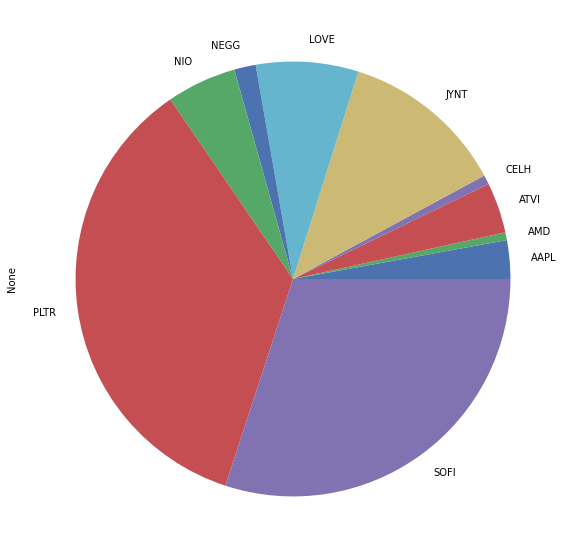

In [65]:
pd.Series(weights).plot.pie();

In [66]:
ef.portfolio_performance(verbose=True);

Expected annual return: 13.0%
Annual volatility: 9.8%
Sharpe Ratio: 1.12


In [67]:
latest_prices = prices.iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=2000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $21.25


{'ATVI': 1, 'JYNT': 3, 'LOVE': 3, 'NEGG': 2, 'NIO': 3, 'PLTR': 34, 'SOFI': 33}

## Add sector constraints to optimize for a better max-sharpe ratio

In [68]:
sector_mapper = {
    'PLTR':'online services', 
    'ATVI':'online services', 
    'AMD':'semiconductors', 
    'NEGG':'online services', 
    'AAPL':'phone & handheld devices',  
    'LOVE':'home furnishings', 
    'NIO':'auto',
    'JYNT':'healthcare', 
    'CELH':'beverages',
    'SOFI':'finance'
}

sector_lower = {'online services': 0.15}
sector_upper = {'online services':0.4}

In [69]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.23685),
             ('AMD', 0.0),
             ('ATVI', 0.02195),
             ('CELH', 0.00187),
             ('JYNT', 0.16966),
             ('LOVE', 0.08135),
             ('NEGG', 0.01621),
             ('NIO', 0.0241),
             ('PLTR', 0.36184),
             ('SOFI', 0.08618)])

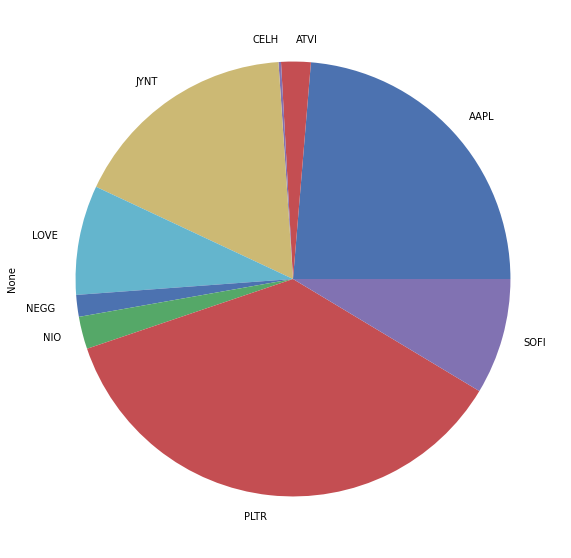

In [70]:
pd.Series(weights).plot.pie();

In [71]:
ef.portfolio_performance(verbose=True);

Expected annual return: 24.2%
Annual volatility: 13.9%
Sharpe Ratio: 1.59


In [72]:
latest_prices = prices.iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=2000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $16.13


{'AAPL': 3,
 'ATVI': 1,
 'JYNT': 4,
 'LOVE': 2,
 'NEGG': 2,
 'NIO': 1,
 'PLTR': 35,
 'SOFI': 10}

## Optimize the portfolio for a given volatility level 

In [73]:
from pypfopt import objective_functions

In [74]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(0.12) # we want a portfolio with at most 12% volatility
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.17439),
             ('AMD', 0.00074),
             ('ATVI', 0.02659),
             ('CELH', 0.00341),
             ('JYNT', 0.15588),
             ('LOVE', 0.08019),
             ('NEGG', 0.01605),
             ('NIO', 0.03297),
             ('PLTR', 0.35735),
             ('SOFI', 0.15242)])

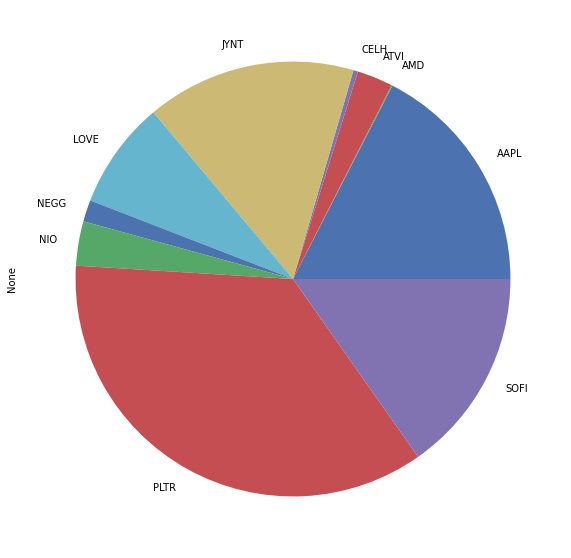

In [75]:
pd.Series(weights).plot.pie();

In [76]:
ef.portfolio_performance(verbose=True);

Expected annual return: 20.8%
Annual volatility: 12.0%
Sharpe Ratio: 1.57
